In [1]:
import numpy as np
import h5py
import string
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
# Meta data of papers
class PaperMeta(object):
    def __init__(self, title, abstract, keyword, rating, url, withdrawn, decision):
        self.title = title  # str
        self.abstract = abstract  # str
        self.keyword = keyword  # list[str]
        self.rating = rating  # list[int]
        self.url = url
        self.withdrawn = withdrawn
        self.decision = decision
        
        if len(self.rating) > 0:
            self.average_rating = np.mean(rating)
        else:
            self.average_rating = -1

            
class Keyword(object):
    def __init__(self, keyword, frequency, rating):
        self.keyword = keyword  # list[str]
        self.frequency = frequency
        self.rating = rating  # list[int]        
    
    def average_rating(self):
        if len(self.rating) > 0:
            return np.mean(self.rating)
        else:
            return -1
    
    def update_frequency(self, frequency):
        self.frequency += frequency
        
    def update_rating(self, rating):
        self.rating = np.concatenate((self.rating, rating))
            
            
def write_meta(meta_list, filename):
    f = h5py.File(filename, 'w')
    for i, m in enumerate(meta_list):
        grp = f.create_group(str(i))
        grp['title'] = m.title
        grp['abstract'] = m.abstract
        grp['keyword'] = '#'.join(m.keyword)
        grp['rating'] = m.rating
        grp['url'] = m.url
        grp['withdrawn'] = m.withdrawn 
        grp['decision'] = m.decision
    f.close()
    
    
def read_meta(filename):
    f = h5py.File(filename, 'r')
    meta_list = []
    for k in list(f.keys()):
        meta_list.append(PaperMeta(
            f[k]['title'].value, 
            f[k]['abstract'].value, 
            f[k]['keyword'].value.split('#'),
            f[k]['rating'].value,
            f[k]['url'].value,
            f[k]['withdrawn'].value,            
        ))
    return meta_list


def crawl_meta(meta_hdf5=None, write_meta_name='data.hdf5'):
    
    if meta_hdf5 is None:
        # Crawl the meta data from OpenReview
        # Set up a browser to crawl from dynamic web pages 
        from selenium import webdriver
        from selenium.webdriver.chrome.options import Options
        
        from pyvirtualdisplay import Display
        display = Display(visible=0, size=(800, 800))
        display.start()
        
        import time
        executable_path = '/usr/local/bin/chromedriver'
        options = Options()
        options.add_argument("--headless")
        browser = webdriver.Chrome(options=options, executable_path=executable_path)            
    
        # Load all URLs for all ICLR submissions
        urls = []
        with open('urls.txt') as f:
            urls = f.readlines()
        urls = [url.strip() for url in urls]
        
        meta_list = [] 
        wait_time = 0.5
        max_try = 1000
        for i, url in enumerate(urls):
            try:
                browser.get(url)
                time.sleep(wait_time)
                key = browser.find_elements_by_class_name("note_content_field")
                key = [k.text for k in key]
                withdrawn = 'Withdrawal confirmation:' in key
                value = browser.find_elements_by_class_name("note_content_value")
                value = [v.text for v in value]

                # title
                title = string.capwords(browser.find_element_by_class_name("note_content_title").text)
                # abstract
                valid = False
                tries = 0
                while not valid:
                    if 'Abstract:' in key:
                        valid = True
                    else:
                        time.sleep(wait_time)
                        tries += 1
                        key = browser.find_elements_by_class_name("note_content_field")
                        key = [k.text for k in key]
                        withdrawn = 'Withdrawal confirmation:' in key
                        value = browser.find_elements_by_class_name("note_content_value")
                        value = [v.text for v in value]                        
                        if tries >= max_try:
                            print('Reached max try: {} ({})'.format(title, url))
                            break
                abstract = ' '.join(value[key.index('Abstract:')].split('\n'))
                # keyword
                if 'Keywords:' in key:
                    keyword = value[key.index('Keywords:')].split(',')
                    keyword = [k.strip(' ') for k in keyword]
                    keyword = [''.join(string.capwords(k).split(' ')) for k in keyword if not k == '']
                    for j in range(len(keyword)):
                        if '-' in keyword[j]:
                            keyword[j] = ''.join([string.capwords(kk) for kk in keyword[j].split('-')])       
                else:
                    keyword = []
                # rating
                rating_idx = [i for i, x in enumerate(key) if x == "Rating:"]
                rating = []
                if len(rating_idx) > 0:
                    for idx in rating_idx:
                        rating.append(int(value[idx].split(":")[0]))
                # decision
                if 'Recommendation:' in key:
                    decision = value[key.index('Recommendation:')]
                else:
                    decision = 'N/A'
                print('[{}] [Abs: {} chars, keywords: {}, ratings: {}, decision: {}] {}'.format(
                    i+1, len(abstract), len(keyword), rating, decision, title))
                meta_list.append(PaperMeta(title, abstract, keyword, rating, url, withdrawn, decision))
            except:
                print('Failed to load {}'.format(url))
            
        # Save the crawled data
        write_meta(meta_list, write_meta_name)
    else:
        # Load the meta data from local
        meta_list = read_meta(meta_hdf5)
    return meta_list

In [3]:
# Get the meta data
# Uncomment this if you want to load the previously stored data file
# meta_list = crawl_meta('data.hdf5')
# Uncomment this if you want to cral data from scratch
meta_list = crawl_meta()
num_withdrawn = len([m for m in meta_list if m.withdrawn])
print('Number of submissions: {} (withdrawn submissions: {})'.format(
    len(meta_list), num_withdrawn))

[1] [Abs: 1194 chars, keywords: 3, ratings: [3, 4, 4], decision: Reject] Unsupervised Video-to-video Translation
[2] [Abs: 1342 chars, keywords: 1, ratings: [5, 6, 4], decision: Reject] Favae: Sequence Disentanglement Using In- Formation Bottleneck Principle
[3] [Abs: 1062 chars, keywords: 0, ratings: [5, 4, 4], decision: Reject] Beyond Winning And Losing: Modeling Human Motivations And Behaviors With Vector-valued Inverse Reinforcement Learning
[4] [Abs: 1235 chars, keywords: 5, ratings: [7, 6, 6], decision: Accept (Poster)] Regularized Learning For Domain Adaptation Under Label Shifts
[5] [Abs: 1599 chars, keywords: 5, ratings: [5, 6, 7], decision: Reject] Efficient Two-step Adversarial Defense For Deep Neural Networks
[6] [Abs: 969 chars, keywords: 5, ratings: [7, 9, 6], decision: Accept (Poster)] Gradient Descent Aligns The Layers Of Deep Linear Networks
[7] [Abs: 1008 chars, keywords: 4, ratings: [5, 7, 4], decision: Reject] A Modern Take On The Bias-variance Tradeoff In Neural Ne

[60] [Abs: 1258 chars, keywords: 4, ratings: [7, 7, 5], decision: Reject] Policy Generalization In Capacity-limited Reinforcement Learning
[61] [Abs: 800 chars, keywords: 3, ratings: [7, 4, 6], decision: Reject] Aim: Adversarial Inference By Matching Priors And Conditionals
[62] [Abs: 1485 chars, keywords: 5, ratings: [7, 8, 7], decision: Accept (Poster)] Towards Metamerism Via Foveated Style Transfer
[63] [Abs: 1875 chars, keywords: 2, ratings: [5, 7, 5], decision: Reject] Understanding & Generalizing Alphago Zero
[64] [Abs: 714 chars, keywords: 4, ratings: [4, 4, 4], decision: Reject] Deep Generative Models For Learning Coherent Latent Representations From Multi-modal Data
[65] [Abs: 3 chars, keywords: 1, ratings: [4, 4, 6], decision: N/A] N/a
[66] [Abs: 388 chars, keywords: 3, ratings: [5, 6, 5], decision: Reject] On The Ineffectiveness Of Variance Reduced Optimization For Deep Learning
[67] [Abs: 799 chars, keywords: 4, ratings: [7, 7, 7], decision: Accept (Poster)] The Role Of Ove

[119] [Abs: 1184 chars, keywords: 4, ratings: [6, 6, 6], decision: Accept (Poster)] Adversarial Imitation Via Variational Inverse Reinforcement Learning
[120] [Abs: 1084 chars, keywords: 2, ratings: [5, 6, 5], decision: Reject] Open Loop Hyperparameter Optimization And Determinantal Point Processes
[121] [Abs: 636 chars, keywords: 4, ratings: [4, 5, 6], decision: Reject] Finding Mixed Nash Equilibria Of Generative Adversarial Networks
[122] [Abs: 643 chars, keywords: 4, ratings: [4, 5, 5], decision: Reject] Over-parameterization Improves Generalization In The Xor Detection Problem
[123] [Abs: 1369 chars, keywords: 6, ratings: [3, 4, 4], decision: Reject] Learning Agents With Prioritization And Parameter Noise In Continuous State And Action Space
[124] [Abs: 1062 chars, keywords: 4, ratings: [4, 4, 6], decision: Reject] Self-supervised Generalisation With Meta Auxiliary Learning
[125] [Abs: 645 chars, keywords: 4, ratings: [2, 2, 3, 1, 2], decision: Reject] Hierarchical Bayesian Modelin

[178] [Abs: 1121 chars, keywords: 4, ratings: [6, 5, 6], decision: Reject] Understanding Gans Via Generalization Analysis For Disconnected Support
[179] [Abs: 1937 chars, keywords: 4, ratings: [5, 4, 4], decision: Reject] Asynchronous Sgd Without Gradient Delay For Efficient Distributed Training
[180] [Abs: 1512 chars, keywords: 5, ratings: [4, 4, 3], decision: Reject] Controlling Over-generalization And Its Effect On Adversarial Examples Detection And Generation
[181] [Abs: 1017 chars, keywords: 3, ratings: [5, 6, 5], decision: Reject] Optimal Margin Distribution Network
[182] [Abs: 1084 chars, keywords: 3, ratings: [8, 7, 6], decision: Accept (Poster)] Learning Implicitly Recurrent Cnns Through Parameter Sharing
[183] [Abs: 754 chars, keywords: 5, ratings: [6, 4, 5], decision: Reject] Human-guided Column Networks: Augmenting Deep Learning With Advice
[184] [Abs: 1087 chars, keywords: 4, ratings: [6, 6, 8], decision: Accept (Poster)] Deep Anomaly Detection With Outlier Exposure
[185] 

[238] [Abs: 1271 chars, keywords: 2, ratings: [7, 8, 7], decision: Accept (Poster)] Instance-aware Image-to-image Translation
[239] [Abs: 1606 chars, keywords: 3, ratings: [5, 3, 4], decision: Reject] Polar Prototype Networks
[240] [Abs: 1336 chars, keywords: 4, ratings: [6, 6, 6], decision: Reject] Graphseq2seq: Graph-sequence-to-sequence For Neural Machine Translation
[241] [Abs: 1506 chars, keywords: 5, ratings: [5, 5, 7], decision: Reject] Nested Dithered Quantization For Communication Reduction In Distributed Training
[242] [Abs: 1003 chars, keywords: 5, ratings: [8, 6, 7], decision: Accept (Poster)] Arm: Augment-reinforce-merge Gradient For Stochastic Binary Networks
[243] [Abs: 709 chars, keywords: 6, ratings: [7, 6, 6], decision: Reject] Improved Gradient Estimators For Stochastic Discrete Variables
[244] [Abs: 1465 chars, keywords: 2, ratings: [7, 7, 7, 6], decision: Accept (Poster)] Deep Bayesian Convolutional Networks With Many Channels Are Gaussian Processes
[245] [Abs: 128

[295] [Abs: 1090 chars, keywords: 4, ratings: [5, 6, 5, 6], decision: Reject] Unlabeled Disentangling Of Gans With Guided Siamese Networks
[296] [Abs: 1320 chars, keywords: 5, ratings: [5, 5, 6], decision: Reject] Mimicking Actions Is A Good Strategy For Beginners: Fast Reinforcement Learning With Expert Action Sequences
[297] [Abs: 1045 chars, keywords: 3, ratings: [5, 4, 3], decision: N/A] The Missing Ingredient In Zero-shot Neural Machine Translation
[298] [Abs: 1080 chars, keywords: 4, ratings: [5, 5, 5], decision: Reject] Dense Morphological Network: An Universal Function Approximator
[299] [Abs: 1588 chars, keywords: 5, ratings: [6, 5, 6], decision: Reject] A Variational Dirichlet Framework For Out-of-distribution Detection
[300] [Abs: 883 chars, keywords: 4, ratings: [5, 5, 5], decision: N/A] End-to-end Learning Of A Convolutional Neural Network Via Deep Tensor Decomposition
[301] [Abs: 1134 chars, keywords: 4, ratings: [8, 4, 8], decision: Accept (Poster)] A Generative Model Fo

[354] [Abs: 1186 chars, keywords: 5, ratings: [5, 5, 4], decision: Reject] Progressive Weight Pruning Of Deep Neural Networks Using Admm
[355] [Abs: 896 chars, keywords: 3, ratings: [5, 4, 4], decision: N/A] Neuron Hierarchical Networks
[356] [Abs: 942 chars, keywords: 9, ratings: [6, 7, 5], decision: Accept (Poster)] Multi-class Classification Without Multi-class Labels
[357] [Abs: 1200 chars, keywords: 4, ratings: [4, 5, 5], decision: Reject] On Breiman’s Dilemma In Neural Networks: Success And Failure Of Normalized Margins
[358] [Abs: 1064 chars, keywords: 5, ratings: [4, 4, 3, 4], decision: Reject] Lsh Microbatches For Stochastic Gradients: Value In Rearrangement
[359] [Abs: 1046 chars, keywords: 4, ratings: [3, 4, 3], decision: N/A] Major-minor Lstms For Word-level Language Model
[360] [Abs: 1186 chars, keywords: 5, ratings: [7, 7, 9], decision: Accept (Oral)] Slalom: Fast, Verifiable And Private Execution Of Neural Networks In Trusted Hardware
[361] [Abs: 1042 chars, keywords: 3,

[413] [Abs: 1001 chars, keywords: 4, ratings: [7, 5, 8], decision: Accept (Poster)] Janossy Pooling: Learning Deep Permutation-invariant Functions For Variable-size Inputs
[414] [Abs: 1848 chars, keywords: 4, ratings: [7, 7, 4], decision: Reject] Estimating Information Flow In Dnns
[415] [Abs: 1728 chars, keywords: 4, ratings: [6, 6, 6], decision: Reject] Recurrent Kalman Networks: Factorized Inference In High-dimensional Deep Feature Spaces
[416] [Abs: 1030 chars, keywords: 7, ratings: [8, 8, 8], decision: Accept (Oral)] Enabling Factorized Piano Music Modeling And Generation With The Maestro Dataset
[417] [Abs: 878 chars, keywords: 8, ratings: [5, 3, 7], decision: Reject] Reduced-gate Convolutional Lstm Design Using Predictive Coding For Next-frame Video Prediction
[418] [Abs: 1155 chars, keywords: 5, ratings: [6, 6, 7], decision: Accept (Poster)] Opportunistic Learning: Budgeted Cost-sensitive Learning From Data Streams
[419] [Abs: 973 chars, keywords: 4, ratings: [7, 7, 8], decisio

[469] [Abs: 1060 chars, keywords: 0, ratings: [6, 6, 6], decision: Reject] Language Model Pre-training For Hierarchical Document Representations
[470] [Abs: 1015 chars, keywords: 2, ratings: [3, 5, 5], decision: Reject] Downsampling Leads To Image Memorization In Convolutional Autoencoders
[471] [Abs: 928 chars, keywords: 5, ratings: [5, 3, 3], decision: Reject] Structured Prediction Using Cgans With Fusion Discriminator
[472] [Abs: 844 chars, keywords: 4, ratings: [7, 7, 7, 7, 6], decision: Accept (Poster)] Subgradient Descent Learns Orthogonal Dictionaries
[473] [Abs: 1383 chars, keywords: 2, ratings: [8, 7, 7], decision: Accept (Poster)] Probabilistic Recursive Reasoning For Multi-agent Reinforcement Learning
[474] [Abs: 767 chars, keywords: 4, ratings: [4, 4, 4], decision: N/A] Explaining Neural Networks Semantically And Quantitatively
[475] [Abs: 1181 chars, keywords: 6, ratings: [7, 6, 7], decision: Accept (Poster)] Diversity-sensitive Conditional Generative Adversarial Networks


[528] [Abs: 904 chars, keywords: 4, ratings: [8, 9, 7], decision: Accept (Poster)] Posterior Attention Models For Sequence To Sequence Learning
[529] [Abs: 1101 chars, keywords: 4, ratings: [8, 7, 7], decision: Accept (Poster)] Dynamic Sparse Graph For Efficient Deep Learning
[530] [Abs: 614 chars, keywords: 0, ratings: [6, 6, 7], decision: Reject] Temporal Gaussian Mixture Layer For Videos
[531] [Abs: 773 chars, keywords: 3, ratings: [4, 8, 4], decision: Reject] Augment Your Batch: Better Training With Larger Batches
[532] [Abs: 1443 chars, keywords: 4, ratings: [7, 6, 5], decision: Accept (Poster)] Optimistic Mirror Descent In Saddle-point Problems: Going The Extra(-gradient) Mile
[533] [Abs: 1222 chars, keywords: 4, ratings: [5, 6, 7], decision: Accept (Poster)] H-detach: Modifying The Lstm Gradient Towards Better Optimization
[534] [Abs: 677 chars, keywords: 0, ratings: [5, 5, 4], decision: N/A] Online Bellman Residue Minimization Via Saddle Point Optimization
[535] [Abs: 1020 char

[585] [Abs: 849 chars, keywords: 2, ratings: [6, 4, 3], decision: N/A] Hiding Objects From Detectors: Exploring Transferrable Adversarial Patterns
[586] [Abs: 1035 chars, keywords: 2, ratings: [6, 8, 8], decision: Accept (Oral)] Transferring Knowledge Across Learning Processes
[587] [Abs: 1023 chars, keywords: 2, ratings: [6, 4, 4], decision: Reject] Architecture Compression
[588] [Abs: 856 chars, keywords: 0, ratings: [5, 5, 4], decision: N/A] Context-aware Forecasting For Multivariate Stationary Time-series
[589] [Abs: 1031 chars, keywords: 3, ratings: [6, 6, 5], decision: Reject] Amortized Context Vector Inference For Sequence-to-sequence Networks
[590] [Abs: 790 chars, keywords: 5, ratings: [7, 7, 7], decision: Reject] Visual Semantic Navigation Using Scene Priors
[591] [Abs: 952 chars, keywords: 4, ratings: [8, 8, 8], decision: Accept (Oral)] Pay Less Attention With Lightweight And Dynamic Convolutions
[592] [Abs: 1531 chars, keywords: 3, ratings: [7, 6, 8], decision: Accept (Post

[645] [Abs: 1179 chars, keywords: 0, ratings: [7, 7, 7], decision: Accept (Poster)] Rotdcf: Decomposition Of Convolutional Filters For Rotation-equivariant Deep Networks
[646] [Abs: 863 chars, keywords: 5, ratings: [4, 3, 6], decision: N/A] Learning Grounded Sentence Representations By Jointly Using Video And Text Information
[647] [Abs: 779 chars, keywords: 3, ratings: [4, 4, 5], decision: Reject] Sequence Modelling With Auto-addressing And Recurrent Memory Integrating Networks
[648] [Abs: 865 chars, keywords: 0, ratings: [5, 5, 4], decision: Reject] Pushing The Bounds Of Dropout
[649] [Abs: 718 chars, keywords: 4, ratings: [6, 5, 6], decision: Reject] Improved Learning Of One-hidden-layer Convolutional Neural Networks With Overlaps
[650] [Abs: 703 chars, keywords: 2, ratings: [6, 5, 5], decision: Reject] The Case For Full-matrix Adaptive Regularization
[651] [Abs: 762 chars, keywords: 3, ratings: [8, 7, 6], decision: Accept (Poster)] Stochastic Optimization Of Sorting Networks Via Co

[704] [Abs: 1170 chars, keywords: 3, ratings: [7, 5, 5], decision: Reject] Domain Adaptation For Structured Output Via Disentangled Patch Representations
[705] [Abs: 1669 chars, keywords: 4, ratings: [4, 5, 5], decision: Reject] Effective And Efficient Batch Normalization Using Few Uncorrelated Data For Statistics' Estimation
[706] [Abs: 1391 chars, keywords: 2, ratings: [5, 5, 4], decision: N/A] Visualizing And Discovering Behavioural Weaknesses In Deep Reinforcement Learning
[707] [Abs: 1098 chars, keywords: 6, ratings: [4, 5, 5], decision: Reject] Unsupervised Expectation Learning For Multisensory Binding
[708] [Abs: 1071 chars, keywords: 3, ratings: [5, 5, 3], decision: Reject] Meta-learning With Individualized Feature Space For Few-shot Classification
[709] [Abs: 1241 chars, keywords: 4, ratings: [3, 7, 4], decision: N/A] Crystalgan: Learning To Discover Crystallographic Structures With Generative Adversarial Networks
[710] [Abs: 724 chars, keywords: 2, ratings: [3, 3, 2], decisio

[760] [Abs: 905 chars, keywords: 4, ratings: [5, 5, 5], decision: Reject] S3ta: A Soft, Spatial, Sequential, Top-down Attention Model
[761] [Abs: 885 chars, keywords: 4, ratings: [8, 7, 9], decision: Accept (Oral)] Large Scale Gan Training For High Fidelity Natural Image Synthesis
[762] [Abs: 1291 chars, keywords: 0, ratings: [7, 7, 6], decision: Accept (Poster)] Structured Adversarial Attack: Towards General Implementation And Better Interpretability
[763] [Abs: 775 chars, keywords: 3, ratings: [6, 7, 8], decision: Accept (Poster)] Learning Sparse Relational Transition Models
[764] [Abs: 475 chars, keywords: 2, ratings: [5, 4, 6], decision: Reject] Spread Divergences
[765] [Abs: 1195 chars, keywords: 0, ratings: [4, 5, 4], decision: Reject] Composition And Decomposition Of Gans
[766] [Abs: 1321 chars, keywords: 0, ratings: [7, 7, 7], decision: Accept (Poster)] Eidetic 3d Lstm: A Model For Video Prediction And Beyond
[767] [Abs: 795 chars, keywords: 0, ratings: [3, 5, 5], decision: N/A

[821] [Abs: 771 chars, keywords: 4, ratings: [4, 5, 5], decision: Reject] Measuring Density And Similarity Of Task Relevant Information In Neural Representations
[822] [Abs: 854 chars, keywords: 7, ratings: [7, 6, 8], decision: Accept (Poster)] Quasi-hyperbolic Momentum And Adam For Deep Learning
[823] [Abs: 910 chars, keywords: 7, ratings: [4, 4, 5], decision: N/A] Salsa-text : Self Attentive Latent Space Based Adversarial Text Generation
[824] [Abs: 1642 chars, keywords: 6, ratings: [7, 6, 7], decision: Accept (Poster)] Minimal Random Code Learning: Getting Bits Back From Compressed Model Parameters
[825] [Abs: 706 chars, keywords: 4, ratings: [6, 7, 6], decision: Accept (Poster)] Reward Constrained Policy Optimization
[826] [Abs: 1090 chars, keywords: 3, ratings: [5, 4, 5], decision: Reject] Differential Equation Networks
[827] [Abs: 991 chars, keywords: 3, ratings: [4, 3, 4], decision: Reject] Contextual Recurrent Convolutional Model For Robust Visual Learning
[828] [Abs: 914 chars

[879] [Abs: 1188 chars, keywords: 0, ratings: [6, 8, 7], decision: Accept (Poster)] Learning To Learn Without Forgetting By Maximizing Transfer And Minimizing Interference
[880] [Abs: 1418 chars, keywords: 3, ratings: [8, 8, 8], decision: Accept (Oral)] Learning Unsupervised Learning Rules
[881] [Abs: 1250 chars, keywords: 2, ratings: [6, 4, 7], decision: Reject] Interactive Parallel Exploration For Reinforcement Learning In Continuous Action Spaces
[882] [Abs: 1049 chars, keywords: 3, ratings: [3, 4, 5], decision: Reject] Guaranteed Recovery Of One-hidden-layer Neural Networks Via Cross Entropy
[883] [Abs: 901 chars, keywords: 4, ratings: [8, 4, 4], decision: Reject] Decaynet: A Study On The Cell States Of Long Short Term Memories
[884] [Abs: 904 chars, keywords: 5, ratings: [7, 7, 6], decision: Accept (Poster)] Adversarial Attacks On Graph Neural Networks Via Meta Learning
[885] [Abs: 774 chars, keywords: 6, ratings: [3, 4, 5], decision: Reject] Incremental Hierarchical Reinforcement

[938] [Abs: 1281 chars, keywords: 4, ratings: [5, 2, 7], decision: Accept (Poster)] Meta-learning With Differentiable Closed-form Solvers
[939] [Abs: 1123 chars, keywords: 3, ratings: [3, 3, 4], decision: Reject] Neural Network Regression With Beta, Dirichlet, And Dirichlet-multinomial Outputs
[940] [Abs: 812 chars, keywords: 3, ratings: [6, 7, 4], decision: Reject] Talk The Walk: Navigating Grids In New York City Through Grounded Dialogue
[941] [Abs: 1039 chars, keywords: 2, ratings: [5, 5, 6], decision: Reject] An Efficient And Margin-approaching Zero-confidence Adversarial Attack
[942] [Abs: 930 chars, keywords: 4, ratings: [4, 4, 7], decision: Reject] The Gan Landscape: Losses, Architectures, Regularization, And Normalization
[943] [Abs: 1355 chars, keywords: 4, ratings: [5, 4, 5], decision: Reject] Partially Mutual Exclusive Softmax For Positive And Unlabeled Data
[944] [Abs: 1367 chars, keywords: 5, ratings: [4, 3, 4], decision: Reject] Feature Transformers: A Unified Representat

[995] [Abs: 1224 chars, keywords: 4, ratings: [5, 6, 6], decision: Reject] An Information-theoretic Metric Of Transferability For Task Transfer Learning
[996] [Abs: 747 chars, keywords: 0, ratings: [5, 3, 5], decision: Reject] Gradient-based Learning For F-measure And Other Performance Metrics
[997] [Abs: 1121 chars, keywords: 4, ratings: [4, 4, 6], decision: Reject] Ace: Artificial Checkerboard Enhancer To Induce And Evade Adversarial Attacks
[998] [Abs: 802 chars, keywords: 3, ratings: [5, 6, 9], decision: Reject] Metropolis-hastings View On Variational Inference And Adversarial Training
[999] [Abs: 1486 chars, keywords: 5, ratings: [4, 4, 8], decision: Reject] Advocacy Learning
[1000] [Abs: 938 chars, keywords: 3, ratings: [7, 7, 7], decision: Accept (Poster)] Function Space Particle Optimization For Bayesian Neural Networks
[1001] [Abs: 1032 chars, keywords: 3, ratings: [3, 5, 5], decision: Reject] Dppnet: Approximating Determinantal Point Processes With Deep Networks
[1002] [Abs: 

[1052] [Abs: 954 chars, keywords: 5, ratings: [5, 7, 6], decision: Accept (Poster)] Kernel Rnn Learning (kernl)
[1053] [Abs: 1251 chars, keywords: 4, ratings: [6, 7, 5], decision: Accept (Poster)] Decoupled Weight Decay Regularization
[1054] [Abs: 1110 chars, keywords: 4, ratings: [5, 2, 3], decision: Reject] Generative Model Based On Minimizing Exact Empirical Wasserstein Distance
[1055] [Abs: 932 chars, keywords: 4, ratings: [7, 9, 9], decision: Accept (Poster)] Benchmarking Neural Network Robustness To Common Corruptions And Perturbations
[1056] [Abs: 890 chars, keywords: 0, ratings: [4, 5, 3], decision: Reject] Second-order Adversarial Attack And Certifiable Robustness
[1057] [Abs: 1669 chars, keywords: 5, ratings: [4, 5, 9], decision: Reject] A Biologically Inspired Visual Working Memory For Deep Networks
[1058] [Abs: 1542 chars, keywords: 1, ratings: [5, 5, 5], decision: Reject] Learning Diverse Generations Using Determinantal Point Processes
[1059] [Abs: 986 chars, keywords: 5, 

[1111] [Abs: 808 chars, keywords: 1, ratings: [7, 8, 8], decision: Accept (Poster)] Adaptive Input Representations For Neural Language Modeling
[1112] [Abs: 783 chars, keywords: 5, ratings: [7, 6, 7], decision: Accept (Poster)] Value Propagation Networks
[1113] [Abs: 927 chars, keywords: 2, ratings: [4, 6, 6], decision: Reject] Graph Neural Networks With Generated Parameters For Relation Extraction
[1114] [Abs: 916 chars, keywords: 4, ratings: [7, 6, 7], decision: Accept (Poster)] Learning Two-layer Neural Networks With Symmetric Inputs
[1115] [Abs: 1129 chars, keywords: 4, ratings: [5, 6, 7], decision: Accept (Poster)] Learning To Propagate Labels: Transductive Propagation Network For Few-shot Learning
[1116] [Abs: 943 chars, keywords: 3, ratings: [7, 7, 7], decision: Accept (Poster)] A Convergence Analysis Of Gradient Descent For Deep Linear Neural Networks
[1117] [Abs: 945 chars, keywords: 8, ratings: [6, 5, 7], decision: Reject] Neural Mmo: A Massively Multiplayer Game Environment 

[1168] [Abs: 686 chars, keywords: 4, ratings: [4, 4, 3], decision: N/A] Efficient Federated Learning Via Variational Dropout
[1169] [Abs: 2139 chars, keywords: 4, ratings: [5, 3, 4], decision: Reject] Learning Latent Semantic Representation From Pre-defined Generative Model
[1170] [Abs: 888 chars, keywords: 4, ratings: [5, 2, 4], decision: N/A] Differentiable Greedy Networks
[1171] [Abs: 1064 chars, keywords: 3, ratings: [4, 4, 5], decision: Reject] Topicgan: Unsupervised Text Generation From Explainable Latent Topics
[1172] [Abs: 732 chars, keywords: 4, ratings: [4, 3, 3], decision: N/A] Learning And Data Selection In Big Datasets
[1173] [Abs: 1864 chars, keywords: 7, ratings: [5, 3, 3], decision: Reject] Localized Random Projections Challenge Benchmarks For Bio-plausible Deep Learning
[1174] [Abs: 727 chars, keywords: 5, ratings: [5, 5, 5], decision: Reject] Model Comparison For Semantic Grouping
[1175] [Abs: 649 chars, keywords: 6, ratings: [4, 4, 3], decision: N/A] Distributed Deep

[1227] [Abs: 1133 chars, keywords: 6, ratings: [], decision: N/A] Exploring Deep Learning Using Information Theory Tools And Patch Ordering
[1228] [Abs: 1280 chars, keywords: 5, ratings: [6, 4, 7], decision: Reject] Perception-aware Point-based Value Iteration For Partially Observable Markov Decision Processes
[1229] [Abs: 1405 chars, keywords: 3, ratings: [4, 4, 5], decision: N/A] Low-cost Parameterizations Of Deep Convolutional Neural Networks
[1230] [Abs: 727 chars, keywords: 0, ratings: [8, 7, 6], decision: Accept (Poster)] Autoencoder-based Music Translation
[1231] [Abs: 1468 chars, keywords: 5, ratings: [5, 4, 4], decision: Reject] Variadic Learning By Bayesian Nonparametric Deep Embedding
[1232] [Abs: 1439 chars, keywords: 0, ratings: [5, 5, 4], decision: Reject] An Investigation Of Model-free Planning
[1233] [Abs: 844 chars, keywords: 3, ratings: [5, 4, 6], decision: Reject] Novel Positional Encodings To Enable Tree-structured Transformers
[1234] [Abs: 912 chars, keywords: 1, r

[1287] [Abs: 1041 chars, keywords: 2, ratings: [4, 5, 5], decision: Reject] Unifying Bilateral Filtering And Adversarial Training For Robust Neural Networks
[1288] [Abs: 1044 chars, keywords: 4, ratings: [5, 6, 5], decision: Reject] Dataset Distillation
[1289] [Abs: 1166 chars, keywords: 3, ratings: [7, 7, 6], decision: Accept (Poster)] On The Convergence Of A Class Of Adam-type Algorithms For Non-convex Optimization
[1290] [Abs: 1221 chars, keywords: 2, ratings: [6, 6, 6], decision: Accept (Poster)] A Max-affine Spline Perspective Of Recurrent Neural Networks
[1291] [Abs: 464 chars, keywords: 2, ratings: [6, 2, 5], decision: Reject] Q-neurons: Neuron Activations Based On Stochastic Jackson's Derivative Operators
[1292] [Abs: 1094 chars, keywords: 4, ratings: [5, 6, 5], decision: Reject] Probabilistic Knowledge Graph Embeddings
[1293] [Abs: 1103 chars, keywords: 3, ratings: [6, 4, 7], decision: Reject] Necst: Neural Joint Source-channel Coding
[1294] [Abs: 837 chars, keywords: 3, ratin

[1345] [Abs: 801 chars, keywords: 6, ratings: [], decision: N/A] Statistical Characterization Of Deep Neural Networks And Their Sensitivity
[1346] [Abs: 1148 chars, keywords: 5, ratings: [3, 2, 3], decision: Reject] Decoupling Gating From Linearity
[1347] [Abs: 1138 chars, keywords: 0, ratings: [7, 7, 7], decision: Accept (Poster)] Execution-guided Neural Program Synthesis
[1348] [Abs: 973 chars, keywords: 5, ratings: [5, 6, 5], decision: Reject] Neural Model-based Reinforcement Learning For Recommendation
[1349] [Abs: 1149 chars, keywords: 0, ratings: [4, 4, 4, 5], decision: Reject] Countdown Regression: Sharp And Calibrated Survival Predictions
[1350] [Abs: 995 chars, keywords: 7, ratings: [5, 6, 6], decision: Accept (Poster)] Adversarial Audio Synthesis
[1351] [Abs: 616 chars, keywords: 3, ratings: [3, 5, 4], decision: Reject] Complexity Of Training Relu Neural Networks
[1352] [Abs: 1158 chars, keywords: 6, ratings: [4, 5, 4], decision: Reject] Dvolver: Efficient Pareto-optimal Neur

[1403] [Abs: 1506 chars, keywords: 4, ratings: [7, 6, 7], decision: Accept (Poster)] Query-efficient Hard-label Black-box Attack: An Optimization-based Approach
[1404] [Abs: 1672 chars, keywords: 4, ratings: [4, 5, 5], decision: Reject] Ssoc: Learning Spontaneous And Self-organizing Communication For Multi-agent Collaboration
[1405] [Abs: 1037 chars, keywords: 5, ratings: [7, 9, 6], decision: Accept (Poster)] Variance Reduction For Reinforcement Learning In Input-driven Environments
[1406] [Abs: 1655 chars, keywords: 5, ratings: [4, 6, 5], decision: Accept (Poster)] Conditional Network Embeddings
[1407] [Abs: 950 chars, keywords: 2, ratings: [4, 6, 6, 6], decision: Reject] Multi-way Encoding For Robustness To Adversarial Attacks
[1408] [Abs: 1380 chars, keywords: 5, ratings: [6, 6, 7], decision: Accept (Poster)] On The Relation Between The Sharpest Directions Of Dnn Loss And The Sgd Step Length
[1409] [Abs: 868 chars, keywords: 3, ratings: [5, 4, 3], decision: Reject] Difference-seekin

[1458] [Abs: 780 chars, keywords: 4, ratings: [6, 4, 7], decision: Accept (Poster)] Neural Persistence: A Complexity Measure For Deep Neural Networks Using Algebraic Topology
[1459] [Abs: 1202 chars, keywords: 2, ratings: [7, 5, 5], decision: N/A] Rethinking Knowledge Graph Propagation For Zero-shot Learning
[1460] [Abs: 935 chars, keywords: 5, ratings: [7, 6, 5], decision: Accept (Poster)] Learning From Positive And Unlabeled Data With A Selection Bias
[1461] [Abs: 1396 chars, keywords: 5, ratings: [6, 6, 7], decision: Accept (Poster)] Double Viterbi: Weight Encoding For High Compression Ratio And Fast On-chip Reconstruction For Deep Neural Network
[1462] [Abs: 885 chars, keywords: 5, ratings: [4, 3, 4], decision: Reject] Delibgan: Coarse-to-fine Text Generation Via Adversarial Network
[1463] [Abs: 1828 chars, keywords: 2, ratings: [6, 6, 4, 3, 7], decision: Reject] Deep Neuroevolution: Genetic Algorithms Are A Competitive Alternative For Training Deep Neural Networks For Reinforcemen

[1512] [Abs: 1144 chars, keywords: 7, ratings: [5, 4, 4], decision: Reject] Deeptwist: Learning Model Compression Via Occasional Weight Distortion
[1513] [Abs: 880 chars, keywords: 2, ratings: [7, 7, 6], decision: Accept (Poster)] Learning Multimodal Graph-to-graph Translation For Molecule Optimization
[1514] [Abs: 1437 chars, keywords: 6, ratings: [6, 5, 6], decision: Reject] Zero-resource Multilingual Model Transfer: Learning What To Share
[1515] [Abs: 987 chars, keywords: 3, ratings: [5, 5, 4], decision: Reject] A Fast Quasi-newton-type Method For Large-scale Stochastic Optimisation
[1516] [Abs: 690 chars, keywords: 7, ratings: [5, 3, 4], decision: Reject] Distilled Agent Dqn For Provable Adversarial Robustness
[1517] [Abs: 1018 chars, keywords: 6, ratings: [6, 7, 5], decision: Reject] Precision Highway For Ultra Low-precision Quantization
[1518] [Abs: 1275 chars, keywords: 0, ratings: [6, 6, 4], decision: Reject] Simple Black-box Adversarial Attacks
[1519] [Abs: 1201 chars, keyword

[1572] [Abs: 1061 chars, keywords: 0, ratings: [6, 6, 6], decision: Reject] Semi-supervised Learning With Multi-domain Sentiment Word Embeddings
[1573] [Abs: 986 chars, keywords: 6, ratings: [7, 6, 6], decision: Reject] Monge-amp\`ere Flow For Generative Modeling
[1574] [Abs: 1655 chars, keywords: 5, ratings: [4, 5, 8], decision: Accept (Poster)] Human-level Protein Localization With Convolutional Neural Networks
[1575] [Abs: 636 chars, keywords: 8, ratings: [7, 5, 3], decision: N/A] Transfer Learning For Estimating Causal Effects Using Neural Networks
[1576] [Abs: 1328 chars, keywords: 3, ratings: [4, 5, 4], decision: Reject] Total Style Transfer With A Single Feed-forward Network
[1577] [Abs: 1160 chars, keywords: 5, ratings: [3, 4, 3], decision: N/A] Learning Spatio-temporal Representations Using Spike-based Backpropagation
[1578] [Abs: 381 chars, keywords: 1, ratings: [4, 4, 5], decision: Reject] Learning A Neural-network-based Representation For Open Set Recognition
[1579] [Abs: 9

In [4]:
rating = []
rating_mean = []
num_rating = []
keywords = []
for m in meta_list:
    rating.extend(m.rating)
    keywords.extend(m.keyword)
    if not m.withdrawn:
        num_rating.append(len(m.rating))
    if len(m.rating) > 0:
        rating_mean.append(m.average_rating)
print('Average rating: {}'.format(np.mean(rating)))

Average rating: 5.323467674223342


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:36: FutureWarning: 'from_array' is deprecated and will be removed in a future version. Please use the pd.Series(..) constructor instead.


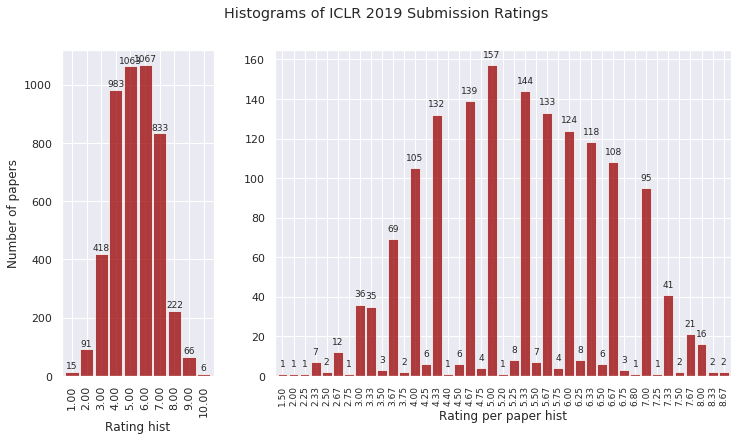

In [5]:
# Plot histograms of ratings
from collections import Counter
from matplotlib import gridspec
import seaborn as sns; sns.set()
fig = plt.figure(figsize=(12, 6))
plt.suptitle('Histograms of ICLR 2019 Submission Ratings')

# Rating hist
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 3]) 
plt.subplot(gs[0])
counterlist =  sorted(Counter(rating).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax1 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax1.set_xlabel('Rating hist')
ax1.set_ylabel('Number of papers')
ax1.set_xticklabels(x_labels)

rects = ax1.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax1.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
            ha='center', va='bottom', fontsize=9)

# Rating per paper hist
plt.subplot(gs[1])
counterlist =  sorted(Counter(rating_mean).most_common())
frequencies = [k[1] for k in counterlist]
bins = [k[0] for k in counterlist]
freq_series = pd.Series.from_array(frequencies)

x_labels = ['{:.2f}'.format(b) for b in bins]

ax2 = freq_series.plot(kind='bar', color='#990000', alpha=0.75, width=0.9)
ax2.set_xlabel('Rating per paper hist')
ax2.set_xticklabels(x_labels, fontsize=9)

rects = ax2.patches
labels = [int(frequencies[i]) for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax2.text(rect.get_x() + rect.get_width() / 2, height + 3, label,
            ha='center', va='bottom', fontsize=9)
plt.show()

In [6]:
# See how many papers are beaten by yours
def PR(rating_mean, your_rating):
    pr = np.sum(your_rating >= np.array(rating_mean))/len(rating_mean)*100
    return pr
my_rating = (6+6+6)/3  # your average rating here
print('Your papar ({:.2f}) beats {:.2f}% of submission '
      '(well, jsut based on the ratings...)'.format(
          my_rating, PR(rating_mean, my_rating)))


# ICLR 2017: accept rate 39.1% (198/507) (15 orals and 183 posters)
# ICLR 2018: accept rate 32% (314/981) (23 orals and 291 posters)
# ICLR 2018: accept rate ?% (?/1580)

Your papar (6.00) beats 72.91% of submission (well, jsut based on the ratings...)


In [7]:
# Count keywords
keywords_hist = Counter(keywords)
del keywords_hist['']
print('{} different keywords before merging'.format(len(keywords_hist)))

# Merge duplicates: CNNs and CNN
duplicates = []
for k in keywords_hist:
    if k+'s' in keywords_hist:
        duplicates.append(k)
for k in duplicates:
    keywords_hist[k] += keywords_hist[k+'s']
    del keywords_hist[k+'s']
print('{} different keywords after merging'.format(len(keywords_hist)))

2886 different keywords before merging
2783 different keywords after merging


In [8]:
# Create keywords list
keywords_list = []
keywords_key_list = []
for m in meta_list:
    for k in [mk for mk in m.keyword if not mk == '']:
        if k not in keywords_hist.keys():
            k = k[:-1]  # strip 's'
        if k in keywords_key_list:
            idx = keywords_key_list.index(k)
            keywords_list[idx].update_frequency(1)
            keywords_list[idx].update_rating(m.rating)
        else:
            # the keyword is new to the list
            k_object = Keyword(k, 1, m.rating)
            keywords_list.append(k_object)
            keywords_key_list.append(k_object.keyword)

67


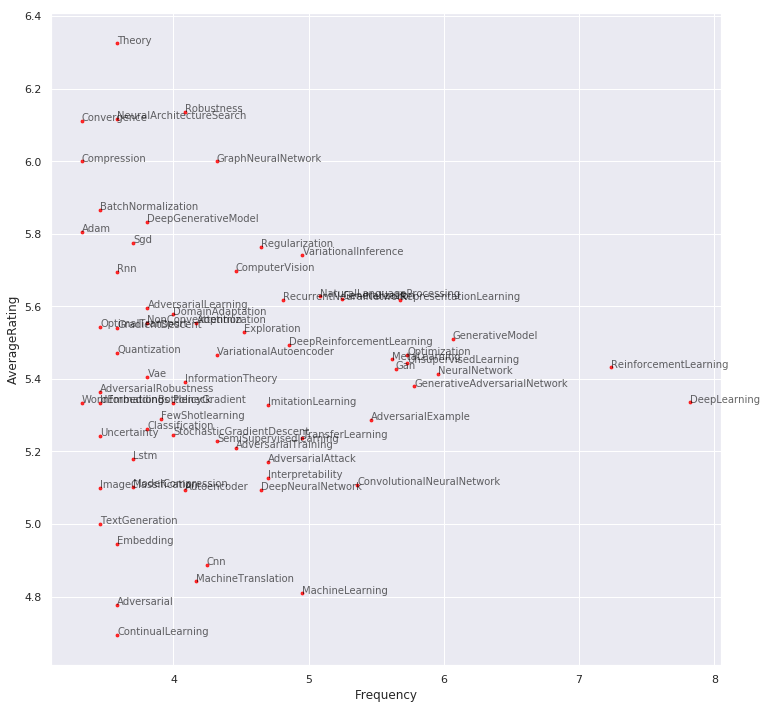

In [9]:
keywords_list_subset = [k for k in keywords_list if k.frequency > 9]
print(len(keywords_list_subset))
y = [k.average_rating() for k in keywords_list_subset]
x = [np.log2(k.frequency) for k in keywords_list_subset]
key = [k.keyword for k in keywords_list_subset]

# Create dataframe
df = pd.DataFrame({
    'Frequency': x,
    'AverageRating': y,
    'Keyword': key
})

sns.set(font_scale=1)
fig = plt.figure(figsize=(12, 12))
p1 = sns.regplot(data=df, x="Frequency", y="AverageRating", fit_reg=False, 
                 marker="o", color="red", logx=True, scatter_kws={'s': 8})
for line in range(0, df.shape[0]):
     p1.text(df.Frequency[line], df.AverageRating[line], df.Keyword[line], 
             horizontalalignment='left', 
             size='small', color='black', alpha=0.6)
plt.show()

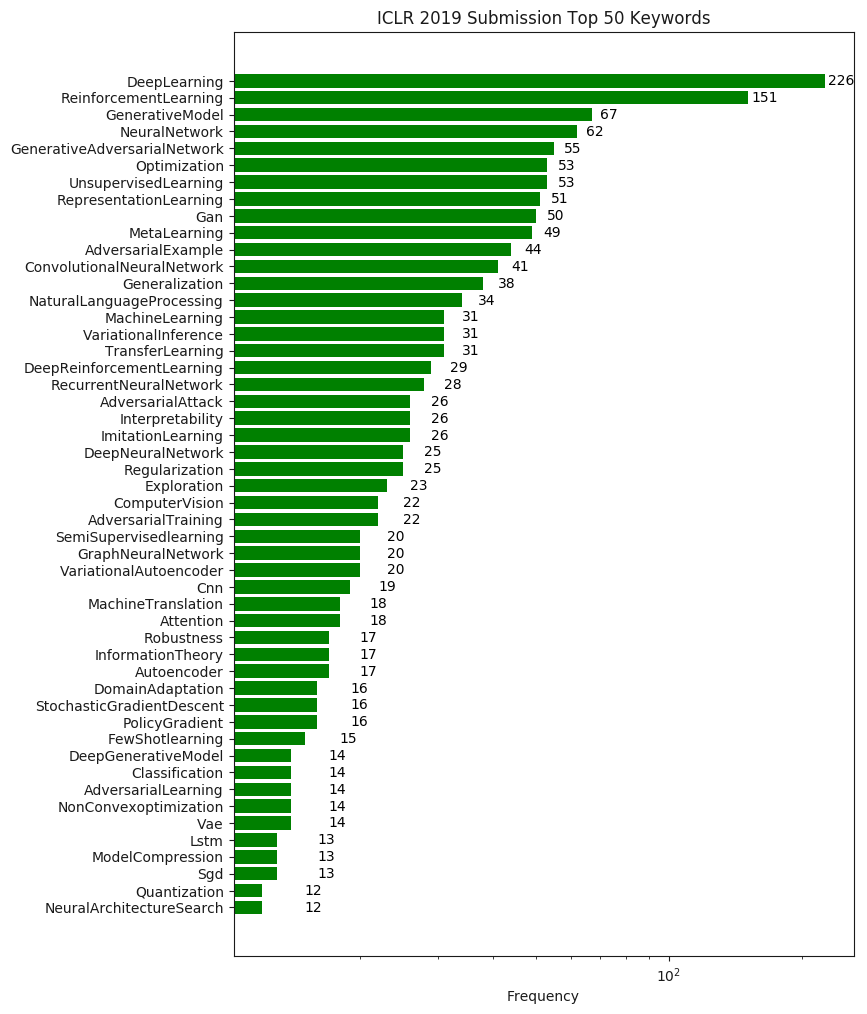

In [10]:
# Show N most common keywords and their frequencies
num_keyowrd = 50
keywords_hist_vis = keywords_hist.most_common(num_keyowrd)

plt.rcdefaults()
fig, ax = plt.subplots(figsize=(8, 12))

key = [k[0] for k in keywords_hist_vis] 
value = [k[1] for k in keywords_hist_vis] 
y_pos = np.arange(len(key))
ax.barh(y_pos, value, align='center', color='green', ecolor='black', log=True)
ax.set_yticks(y_pos)
ax.set_yticklabels(key, rotation=0, fontsize=10)
ax.invert_yaxis() 
for i, v in enumerate(value):
    ax.text(v + 3, i + .25, str(v), color='black', fontsize=10)
# ax.text(y_pos, value, str(value))
ax.set_xlabel('Frequency')
ax.set_title('ICLR 2019 Submission Top {} Keywords'.format(num_keyowrd))

plt.show()

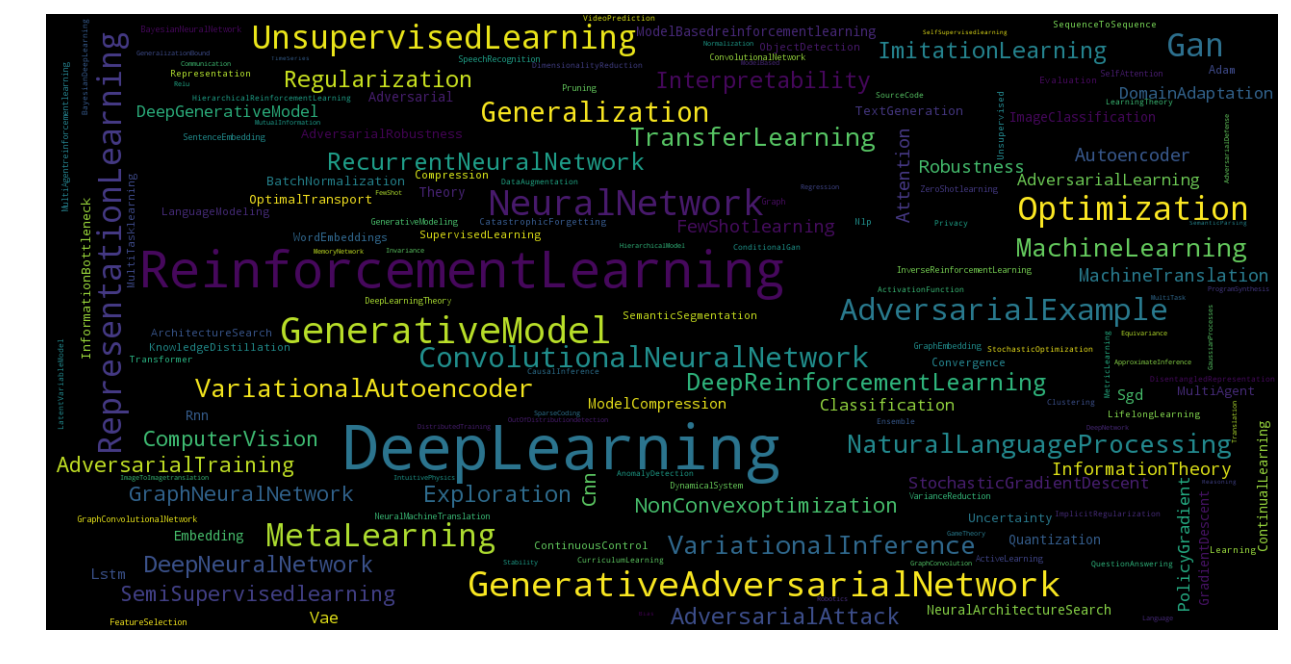

In [11]:
# Show the word cloud forming by keywords
from wordcloud import WordCloud
wordcloud = WordCloud(max_font_size=64, max_words=160, 
                      width=1280, height=640,
                      background_color="black").generate(' '.join(keywords))
plt.figure(figsize=(16, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

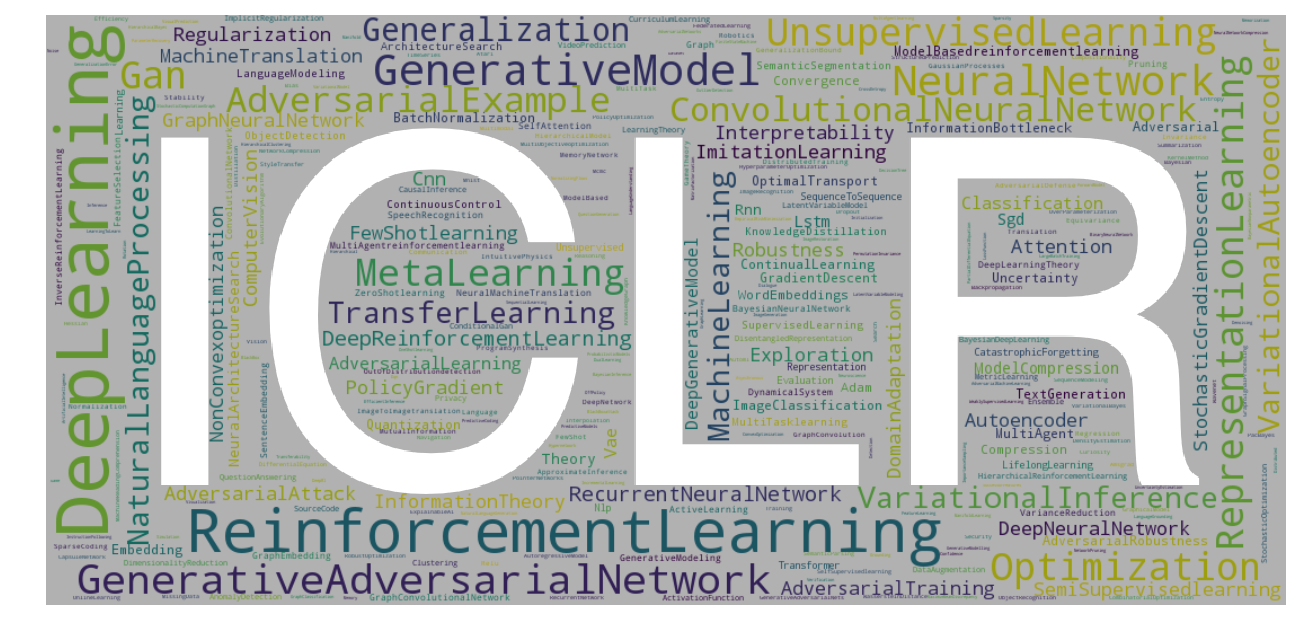

In [12]:
# Show the word cloud with an ICLR logo
from imageio import imread
logo = imread('asset/logo.png')
wordcloud = WordCloud(max_font_size=64, max_words=300, 
                      width=1280, height=640,
                      background_color="white", mask=logo).generate(' '.join(keywords))
plt.figure(figsize=(16, 8), frameon=False)
plt.imshow(logo)
plt.imshow(wordcloud, interpolation="bilinear",  alpha=.7)
plt.axis("off")
plt.show()

In [13]:
num_valid = len(meta_list) - num_withdrawn
num_missing_rating = num_valid*3 - np.sum(np.clip(num_rating, 0, 3))
print('Number of missing reviews: {} ({:.4f}%)'.format(
    num_missing_rating, 100*float(num_missing_rating)/(num_valid*3)))

Number of missing reviews: 6 (0.1410%)


In [14]:
# the papers that don't have 3 reviews
for m in meta_list:
    if len(m.rating) < 3 and not m.withdrawn:
        print(m.title, m.url, m.rating)

Improving On-policy Learning With Statistical Reward Accumulation https://openreview.net/forum?id=HJgZrsC5t7 [4, 5]
Fast Exploration With Simplified Models And Approximately Optimistic Planning In Model Based Reinforcement Learning https://openreview.net/forum?id=HygS7n0cFQ [5, 4]
Fast Binary Functional Search On Graph https://openreview.net/forum?id=Bkg5aoAqKm [4, 5]
A Solution To China Competitive Poker Using Deep Learning https://openreview.net/forum?id=rJzoujRct7 [3, 2]
Peernets: Exploiting Peer Wisdom Against Adversarial Attacks https://openreview.net/forum?id=Sk4jFoA9K7 [7, 6]
S-system, Geometry, Learning, And Optimization: A Theory Of Neural Networks https://openreview.net/forum?id=HyxUIj09KX [4, 4]


In [15]:
# Write all the data to README
import datetime
with open('README.md', 'r+') as readme:
    lines = readme.readlines()

data_title = '## <a id="Data"></a>All ICLR 2019 OpenReview data\n'
idx = lines.index(data_title)
lines = lines[:idx]

with open('README.md', 'w') as readme:
    for line in lines:
        readme.write(line)
    readme.write(data_title)
    readme.write('Collected at {}\n\n'.format(datetime.datetime.now()))
    readme.write('Number of submissions: {} (withdrawn submissions: {})\n\n'.format(
        len(meta_list), num_withdrawn))
    readme.write('| Rank | Average Rating | Title | Ratings | Variance | Decision |\n')
    readme.write('| --- | --- | --- | --- | --- | --- |\n')
    non_empty_rating_meta_list = [m for m in meta_list if not len(m.rating)==0]
    empty_rating_meta_list = [m for m in meta_list if len(m.rating)==0]    
    sorted_idx = np.argsort([np.mean(m.rating) for m in non_empty_rating_meta_list])[::-1]
    for i, idx in enumerate(sorted_idx):
        m = non_empty_rating_meta_list[idx]
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1, np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',  
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))
    for i, m in enumerate(empty_rating_meta_list):
        readme.write('| {} | {:.2f} | [{}]({}) | {} | {:.2f} | {} |\n'.format(
            i+1+len(non_empty_rating_meta_list), np.mean(m.rating), 
            m.title if not m.withdrawn else '~~'+m.title+'~~',
            m.url, ', '.join([str(r) for r in list(m.rating)]),
            np.std(m.rating), m.decision
        ))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
